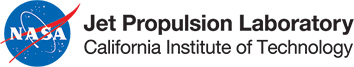

# **Delta-X Workshop**

## **Module 5: Water Quality Indicators and Total Suspended Solids:**
*Created by Alexandra Christensen (April 2022)*

*Jet Propulsion Laboratory, California Institute of Technology*

*© 2022 California Institute of Technology. Government sponsorship acknowledged.*


Data Access:

>https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=2080

>https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=2075


Citations:

> Fichot, C.G., J. Harringmeyer, and M. Weiser. 2022. Delta-X: In Situ Water Quality Indicators across MRD, LA, USA, 2021. ORNL DAAC, Oak Ridge, Tennessee, USA. https://doi.org/10.3334/ORNLDAAC/2080


> Fichot, C.G., N. Ghosh, J. Harringmeyer, and M. Weiser. 2022. Delta-X: Total Suspended Solids Concentration across MRD, LA, USA, 2021. ORNL DAAC, Oak Ridge, Tennessee, USA. https://doi.org/10.3334/ORNLDAAC/2075

Authors:

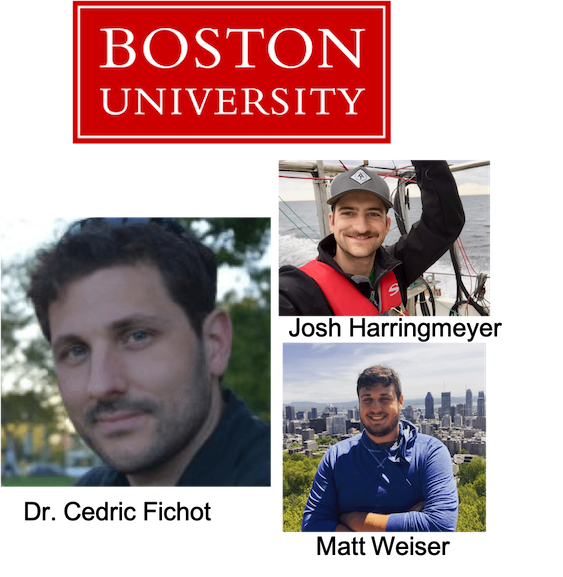

In [1]:
!pip install rasterio
import rasterio
import rasterio.plot

from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import string
from scipy import stats

input_dir = os.getcwd()
print(input_dir)


     |████████████████████████████████| 19.3 MB 2.4 MB/s 
/content


**If you are not using Google Colab, don't run the next cell. It will change your input directory to the shared Google Drive folder, which you should only do if you're using Google Colab**

Second, we will grant access to your Google Drive account. If you have not done this before (or it's been a while), you will need to approve access. There will be 2 popups, make sure to allow both.

In [2]:
#For access to Google Drive files
from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#For saving to Google Drive
from google.colab import drive

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
Gdrive = GoogleDrive(gauth)

drive.mount('/content/drive',force_remount=True)
input_dir = '/content/drive/My Drive/DeltaX_Workshop_2022/Tutorials/0_Field/Module5_WaterQuality'


Mounted at /content/drive


We also need to import a basemap that we'll use to make maps below.

In [3]:
basemap = rasterio.open(input_dir + '/basemap.tif')


There are two datasets we'll work with in this module. 

1.   The water quality indicators dataset for variables measured multiparameter probe (indicators_file)

2.   The total suspended solids dataset from water sampled collected and filtered (tss_file)

In [4]:
indicators_file = pd.read_csv(input_dir + "/DeltaX_Insitu_WQ_Indicators_V2_2080/data/DeltaX_WQ_Indicators_Spring2021.csv")

indicators_file = indicators_file.replace('not_collected',np.nan)
indicators_file = indicators_file.astype({'turbidity':'float','temperature':'float','salinity':'float','chlorophyll_a_fluorescence':'float'})


In [5]:
tss_file = pd.read_csv(input_dir + "/DeltaX_TSS_Concentration_V2_2075/data/DeltaX_TSS_Spring2021.csv")

tss_file = tss_file.replace('not_collected',np.nan)
tss_file = tss_file.astype({'tss_concentration':'float','depth':'float'})


The sample IDs are the same for both datasets, so we can combine then.

In [6]:
water_quality = pd.merge(indicators_file.reset_index(), tss_file.reset_index(),  how='left', on=['basin', 'site_id', 'campaign', 'latitude', 'longitude', 'date', 'time','depth'])
water_quality.head()


,index_x,basin,site_id,campaign,latitude,longitude,date,time,depth,turbidity,SD_turbidity,salinity,SD_salinity,temperature,SD_temperature,chlorophyll_a_fluorescence,SD_chlorophyll_a_fluorescence,index_y,tss_concentration,SD_tss_concentration
0,0,Terrebonne,TB_0405_D1,Spring 2021,29.262435,-90.935865,4/5/21,20:34,0.5,21.73,0.06,7.28,0.01,20.44,0.00,2.56,0.00,0,NaN,NaN
1,1,Terrebonne,TB_0405_S1,Spring 2021,29.343312,-90.885895,4/5/21,15:30,0.5,10.28,0.10,2.15,0.00,19.94,0.00,1.36,0.03,1,18.1,1.0
2,2,Terrebonne,TB_0405_S2,Spring 2021,29.258782,-90.928929,4/5/21,17:15,0.5,21.68,0.56,4.38,0.00,19.28,0.00,2.33,0.24,2,48.7,2.4
3,3,Terrebonne,TB_0405_S3,Spring 2021,29.133525,-90.833530,4/5/21,18:15,0.5,9.88,1.27,20.05,0.06,19.92,0.16,1.15,0.06,3,28.5,5.2
4,4,Terrebonne,TB_0405_S4,Spring 2021,29.170795,-90.825446,4/5/21,19:18,0.5,9.42,0.21,16.25,0.05,21.33,0.05,1.09,0.08,4,25.6,0.9


Be very careful with column names. Make sure you use the exact column title, which can sometimes have unusual characters (like spaces) that may be unexpected. When in doubt, you can list all the columns of the dataset using:


In [7]:
water_quality.columns

Index(['index_x', 'basin', 'site_id', 'campaign', 'latitude', 'longitude',
       'date', 'time', 'depth', 'turbidity', 'SD_turbidity', 'salinity',
       'SD_salinity', 'temperature', 'SD_temperature',
       'chlorophyll_a_fluorescence', 'SD_chlorophyll_a_fluorescence',
       'index_y', 'tss_concentration', 'SD_tss_concentration'],
      dtype='object')

## Let's start by mapping average values across the entire study area

We can calculate the average value for each site

In [8]:
site_means = water_quality.groupby(['site_id','longitude','latitude'])[['turbidity','temperature','salinity','chlorophyll_a_fluorescence','tss_concentration']].agg(np.mean)

For simplicity, we will only map turbidity and salinity. You can change the c variable if you want to see the others.

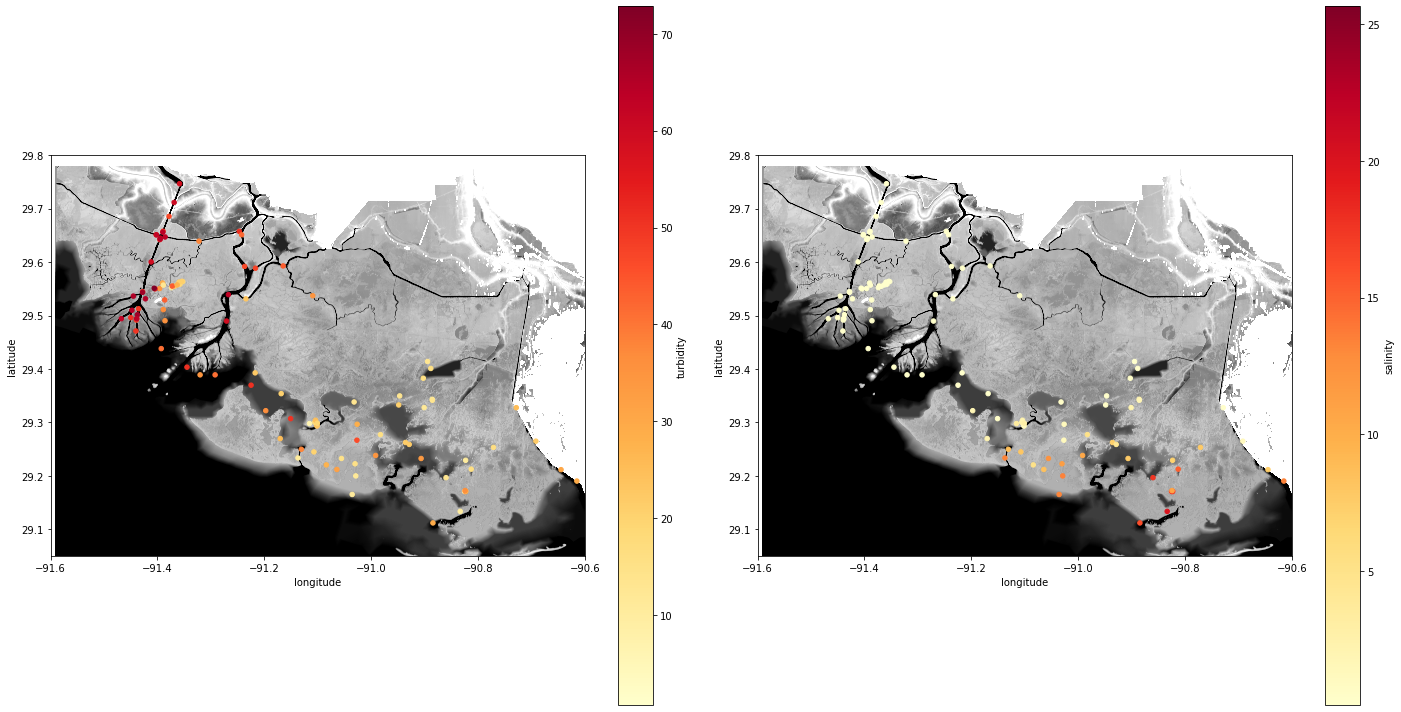

In [9]:
fig, [ax1,ax2] = plt.subplots(ncols=2,figsize = (20,10))

rasterio.plot.show(basemap,vmin=-2,vmax=2,transform=basemap.transform,ax=ax1,cmap='Greys_r')
site_means.reset_index().plot(x="longitude", y="latitude", ax=ax1,kind="scatter", c="turbidity",colormap="YlOrRd")
ax1.axis([-91.6,-90.6,29.05,29.8])
rasterio.plot.show(basemap,vmin=-2,vmax=2,transform=basemap.transform,ax=ax2,cmap='Greys_r')
site_means.reset_index().plot(x="longitude", y="latitude", ax=ax2,kind="scatter", c="salinity",colormap="YlOrRd")
ax2.axis([-91.6,-90.6,29.05,29.8])

plt.tight_layout()

## Now we can compare basins with simple averages for each water quality parameter.

In [10]:
water_quality_means = water_quality.groupby('basin')[['turbidity','temperature','salinity','chlorophyll_a_fluorescence','tss_concentration']].agg(np.mean)
water_quality_stds = water_quality.groupby('basin')[['turbidity','temperature','salinity','chlorophyll_a_fluorescence','tss_concentration']].agg(np.std)
water_quality_count = water_quality.groupby('basin')[['turbidity','temperature','salinity','chlorophyll_a_fluorescence','tss_concentration']].agg(np.count_nonzero)
water_quality_means.head()

,turbidity,temperature,salinity,chlorophyll_a_fluorescence,tss_concentration
basin,,,,,
Atchafalaya,46.146071,16.298929,0.137143,0.801429,80.863636
Terrebonne,21.324815,21.361667,7.259259,2.155000,40.558000


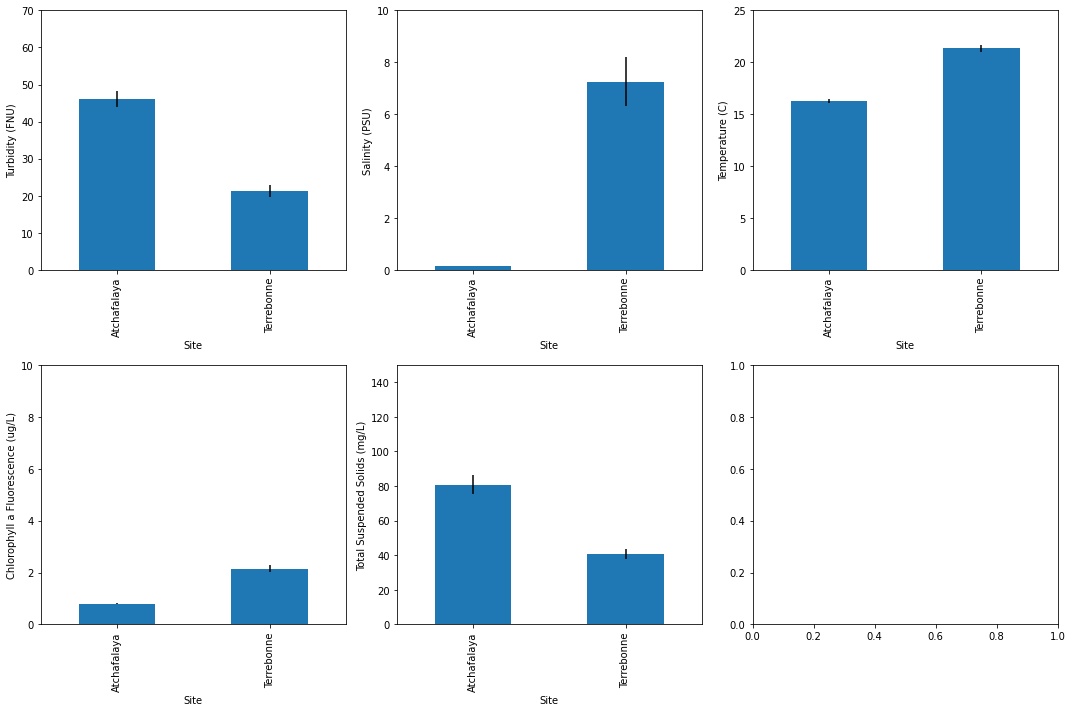

In [11]:
fig, [[ax1,ax2,ax3],[ax4,ax5,ax6]] = plt.subplots(ncols=3,nrows=2, figsize=(15,10))

water_quality_means.unstack()['turbidity'].plot(kind='bar', stacked=False,ax = ax1,yerr = water_quality_stds.unstack()['turbidity']/(np.sqrt(water_quality_count.unstack()['turbidity'])))
ax1.set(xlabel='Site', ylabel='Turbidity (FNU)',ylim=[0,70])

water_quality_means.unstack()['salinity'].plot(kind='bar', stacked=False,ax = ax2,yerr = water_quality_stds.unstack()['salinity']/(np.sqrt(water_quality_count.unstack()['salinity'])))
ax2.set(xlabel='Site', ylabel='Salinity (PSU)',ylim=[0,10])

water_quality_means.unstack()['temperature'].plot(kind='bar', stacked=False,ax = ax3,yerr = water_quality_stds.unstack()['temperature']/(np.sqrt(water_quality_count.unstack()['temperature'])))
ax3.set(xlabel='Site', ylabel='Temperature (C)',ylim=[0,25])

water_quality_means.unstack()['chlorophyll_a_fluorescence'].plot(kind='bar', stacked=False,ax = ax4,yerr = water_quality_stds.unstack()['chlorophyll_a_fluorescence']/(np.sqrt(water_quality_count.unstack()['chlorophyll_a_fluorescence'])))
ax4.set(xlabel='Site', ylabel='Chlorophyll a Fluorescence (ug/L)',ylim=[0,10])

water_quality_means.unstack()['tss_concentration'].plot(kind='bar', stacked=False,ax = ax5,yerr = water_quality_stds.unstack()['tss_concentration']/(np.sqrt(water_quality_count.unstack()['tss_concentration'])))
ax5.set(xlabel='Site', ylabel='Total Suspended Solids (mg/L)',ylim=[0,150])

plt.tight_layout()



## What trends do you notice between basins?



Let's look at a particular study area: CRMS 0421. 
Four samples were collected here, we will select only those and compare water quality variables for those sites.



Samples TB_0405 (high tide) and TB_0422 (rising tide) are in the larger channel, collected on different days.

Samples TB_0409 (rising tide) and TB_0417 (high tide) are in the smaller channel, collected on differnet days.


In [12]:
sites_CRMS0421 = ['TB_0405_S4','TB_0422_S1','TB_0417_S1','TB_0409_S2']
CRMS0421 = water_quality[water_quality['site_id'].isin(sites_CRMS0421)].reset_index()


In [13]:
## Add in tide and channel information to the dataframe

channel_info = ['Large/High Tide','Small/Rising Tide','Small/High Tide','Large/Rising Tide']
CRMS0421['channel'] = channel_info


Let's plot them 

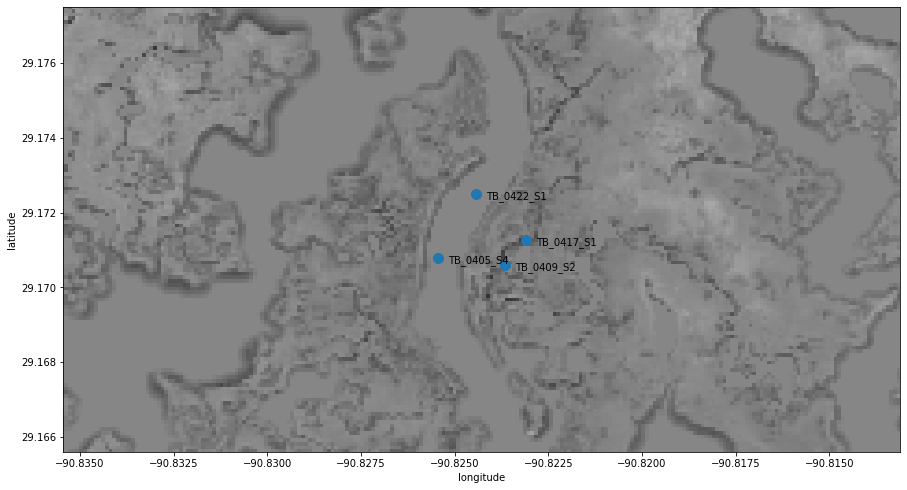

In [14]:
xmin = np.min(CRMS0421['longitude'])
ymin = np.min(CRMS0421['latitude'])
xmax = np.max(CRMS0421['longitude'])
ymax = np.max(CRMS0421['latitude'])

fig, ax = plt.subplots(figsize=(15,15))
rasterio.plot.show(basemap,transform=basemap.transform,vmin=-1,vmax=2,ax=ax,cmap='Greys_r')
plt.axis([xmin-0.01, xmax+0.01, ymin-0.005, ymax+0.005])
import string
CRMS0421.plot(x="longitude", y="latitude",ax=ax,kind="scatter",s=100)

for k, v in CRMS0421.iterrows():
    ax.annotate(v['site_id'],[v['longitude'],v['latitude']],
               xytext=(10,-5), textcoords='offset points',
               family='sans-serif', fontsize=10, color='black')

There are standard deviation columns for the parameters measured with the probe. These are calculated over the 2 minute sampling period that the instrument is submerged in the water. We will use these for the error bars in the plots below.

[(0.0, 4.0),
 Text(0, 0.5, 'Chlorophyll A Fluorescence'),
 Text(0.5, 0, 'Channel/Tide')]

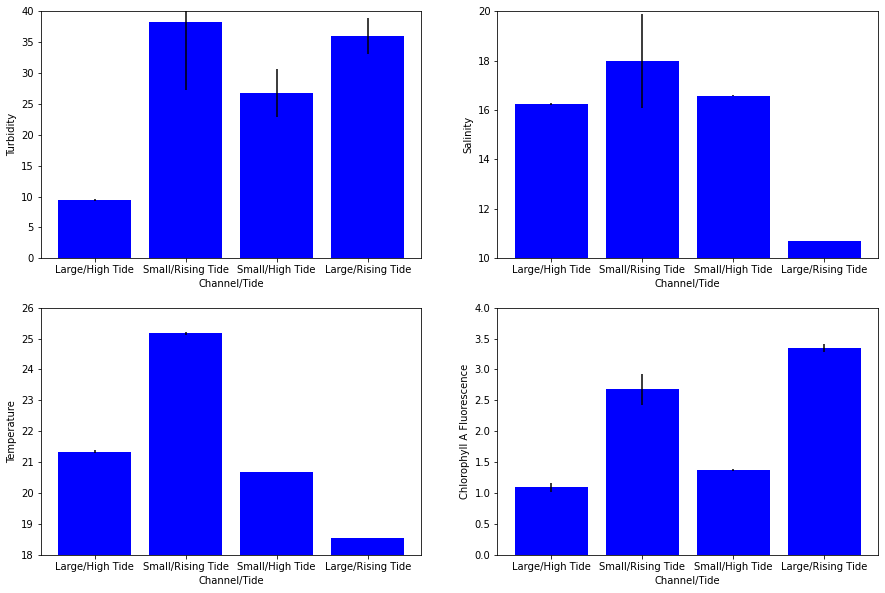

In [15]:
fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(ncols=2,nrows=2, figsize=(15,10))
ax1.bar(CRMS0421['channel'], CRMS0421['turbidity'].astype(float), yerr = CRMS0421['SD_turbidity'].astype(float),
        color ='blue')
ax1.set(xlabel='Channel/Tide', ylabel='Turbidity',ylim=[0,40])

ax2.bar(CRMS0421['channel'], CRMS0421['salinity'].astype(float), yerr = CRMS0421['SD_salinity'].astype(float),
        color ='blue')
ax2.set(xlabel='Channel/Tide', ylabel='Salinity',ylim=[10,20])

ax3.bar(CRMS0421['channel'], CRMS0421['temperature'].astype(float), yerr = CRMS0421['SD_temperature'].astype(float),
        color ='blue')
ax3.set(xlabel='Channel/Tide', ylabel='Temperature',ylim=[18,26])

ax4.bar(CRMS0421['channel'], CRMS0421['chlorophyll_a_fluorescence'].astype(float), yerr = CRMS0421['SD_chlorophyll_a_fluorescence'].astype(float),
        color ='blue')
ax4.set(xlabel='Channel/Tide', ylabel='Chlorophyll A Fluorescence',ylim=[0,4])


## Can you draw any conclusions about the small vs. large channels or between high vs. rising tide?

This is just an example of how can you subset these data for a particular study area.

# Now we will see how these parameters are related to each other. Do you expect correlation between particular parameters?

We'll go back to the entire dataset to look at relationship between different water quality parameters.

Let's start with TSS and turbidity, which is often used as a proxy for TSS. These should be strongly correlated, as this relationship is commonly used to convert turbidity values to total suspended solids.

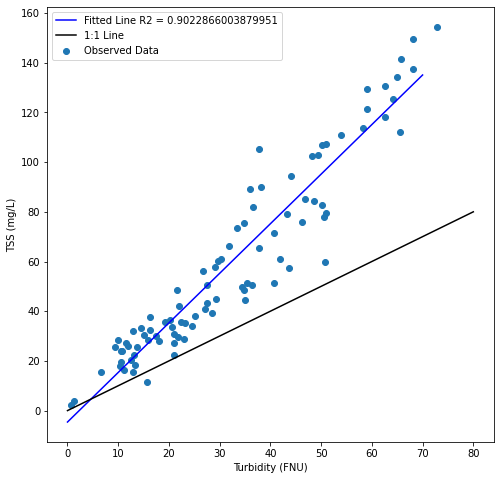

In [16]:
fig, ax1 = plt.subplots(figsize=(8,8))
ax1.scatter(water_quality['turbidity'], water_quality['tss_concentration'],label='Observed Data')
ax1.set(xlabel='Turbidity (FNU)', ylabel='TSS (mg/L)')
x = water_quality['turbidity']
y = water_quality['tss_concentration']
mask = ~np.isnan(x) & ~np.isnan(y)
res = stats.linregress(x[mask],y[mask])

ax1.plot(np.linspace(0,70,10), res.intercept + res.slope*np.linspace(0,70,10), 'blue',label='Fitted Line R2 = %s' %(res.rvalue**2))
ax1.plot(np.linspace(0,80,10),np.linspace(0,80,10),c='black',label='1:1 Line')
ax1.legend()


Now we can plot several different configuration. Here are a few examples. Feel free to change variables to look at different combinations.

[Text(0, 0.5, 'Temperature'), Text(0.5, 0, 'Chlorophyll_a_fluorescence')]

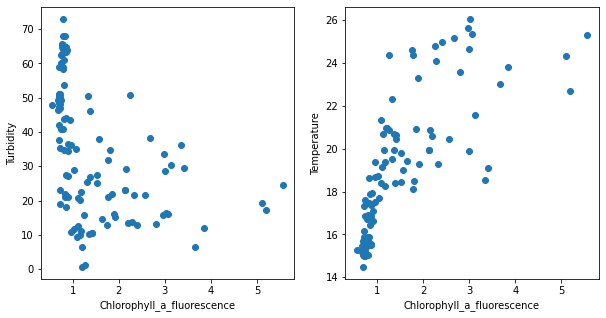

In [17]:
fig, [ax1,ax2] = plt.subplots(ncols=2,figsize=(10,5))

ax1.scatter(water_quality['chlorophyll_a_fluorescence'].astype(float), water_quality['turbidity'].astype(float))
ax1.set(xlabel='Chlorophyll_a_fluorescence', ylabel='Turbidity')


ax2.scatter(water_quality['chlorophyll_a_fluorescence'].astype(float), water_quality['temperature'].astype(float))
ax2.set(xlabel='Chlorophyll_a_fluorescence', ylabel='Temperature')

# Try out other combinations and discuss what trends you notice.